# Small Business Ecosystem Analysis

## Executive Summary

This notebook analyzes **small business dynamics and entrepreneurship patterns** using the KRL Suite to combine County Business Patterns data with economic indicators.

### KRL Suite Components Used

- **krl_data_connectors.community**: `CountyBusinessPatternsConnector`, `FREDBasicConnector`, `BLSBasicConnector`
- **krl_models**: `LocationQuotientModel` for industry specialization
- **krl_core**: Logging utilities

### Key Intelligence Questions

1. Which industries are growing vs declining?
2. What regional patterns exist in business formation?
3. How do economic conditions affect small business survival?
4. Which sectors show entrepreneurship opportunity?

**Estimated Time:** 20-25 minutes  
**Difficulty:** Intermediate

## 1. Environment Setup

In [1]:
# =============================================================================
# Small Business Ecosystem Analysis: Environment Setup
# =============================================================================
import os
import sys
import warnings
from datetime import datetime
import importlib

# Add KRL package paths (handles spaces in path correctly)
_krl_base = os.path.expanduser("~/Documents/GitHub/KRL/Private IP")
for _pkg in ["krl-open-core/src", "krl-data-connectors/src", "krl-model-zoo-v2-2.0.0-community"]:
    _path = os.path.join(_krl_base, _pkg)
    if _path not in sys.path:
        sys.path.insert(0, _path)

# Load environment variables from .env file
from dotenv import load_dotenv
_env_path = os.path.expanduser("~/Documents/GitHub/KRL/Private IP/krl-tutorials/.env")
load_dotenv(_env_path)

# Force complete reload of KRL modules to pick up any changes
_modules_to_reload = [k for k in sys.modules.keys() if k.startswith(('krl_core', 'krl_data_connectors', 'krl_models'))]
for _mod in _modules_to_reload:
    del sys.modules[_mod]

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# KRL Suite Imports
# =============================================================================
from krl_data_connectors.community import (
    CountyBusinessPatternsConnector,
    FREDBasicConnector,
    BLSBasicConnector,
)
from krl_models import LocationQuotientModel, ShiftShareModel
from krl_core import get_logger

warnings.filterwarnings('ignore', category=FutureWarning)
logger = get_logger("SmallBusinessEcosystem")

# Colorblind-safe palette
COLORBLIND_SAFE = ['#0072B2', '#E69F00', '#009E73', '#CC79A7', '#56B4E9', '#D55E00']

print("=" * 65)
print("🏪 Small Business Ecosystem Analysis")
print("=" * 65)
print(f"📅 Execution Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🔑 FRED API Key: {'✓ Loaded' if os.getenv('FRED_API_KEY') else '✗ Not found'}")
print("=" * 65)

🏪 Small Business Ecosystem Analysis
📅 Execution Time: 2025-11-28 04:31:07
🔑 FRED API Key: ✗ Not found


In [2]:
# =============================================================================
# Initialize KRL Data Connectors
# =============================================================================
cbp = CountyBusinessPatternsConnector()
fred = FREDBasicConnector()
bls = BLSBasicConnector()

print("✓ KRL Data Connectors initialized:")
print(f"   • CountyBusinessPatternsConnector - Business establishment data")
print(f"   • FREDBasicConnector - Economic indicators")
print(f"   • BLSBasicConnector - Employment data")

print(f"\n📊 KRL Models available:")
print(f"   • LocationQuotientModel - Industry specialization")
print(f"   • ShiftShareModel - Regional competitiveness")

{"timestamp": "2025-11-28T09:31:11.609284Z", "level": "WARNING", "name": "CountyBusinessPatternsConnector", "message": "No API key provided", "source": {"file": "base_connector.py", "line": 74, "function": "__init__"}, "levelname": "WARNING", "taskName": "Task-33", "connector": "CountyBusinessPatternsConnector"}
{"timestamp": "2025-11-28T09:31:11.609628Z", "level": "INFO", "name": "CountyBusinessPatternsConnector", "message": "Connector initialized", "source": {"file": "base_connector.py", "line": 81, "function": "__init__"}, "levelname": "INFO", "taskName": "Task-33", "connector": "CountyBusinessPatternsConnector", "cache_dir": "/Users/bcdelo/.krl_cache/countybusinesspatternsconnector", "cache_ttl": 3600, "has_api_key": false}
{"timestamp": "2025-11-28T09:31:11.609873Z", "level": "INFO", "name": "CountyBusinessPatternsConnector", "message": "Initialized County Business Patterns connector", "source": {"file": "census_cbp_summary.py", "line": 104, "function": "__init__"}, "levelname": "

## 2. Business Ecosystem Data Collection

Using KRL connectors to gather business dynamics data, then generating a comprehensive metro-level dataset for ecosystem analysis.

In [3]:
# =============================================================================
# Collect Economic Context Data from KRL Connectors
# =============================================================================

# Get economic context from FRED
try:
    gdp_data = fred.get_series('GDP', start_year=2018, end_year=2024)
    print(f"✓ FRED GDP data: {len(gdp_data)} observations")
except Exception as e:
    print(f"⚠ FRED API not available (demo mode): {e}")
    gdp_data = pd.DataFrame({'date': pd.date_range('2018-01-01', periods=28, freq='Q'),
                             'value': np.random.normal(22000, 500, 28)})

# Get employment data from BLS
try:
    unemployment = bls.get_unemployment_rate()
    print(f"✓ BLS unemployment data: {len(unemployment)} observations")
except Exception as e:
    print(f"⚠ BLS API not available (demo mode): {e}")
    unemployment = pd.DataFrame({'date': pd.date_range('2018-01-01', periods=72, freq='M'),
                                 'value': np.random.normal(4.5, 1.5, 72)})

# =============================================================================
# Generate Business Ecosystem Dataset
# =============================================================================

def generate_business_data(n_areas: int = 150, seed: int = 42) -> pd.DataFrame:
    """
    Generate synthetic small business ecosystem data by geographic area.
    """
    np.random.seed(seed)
    
    # Latent ecosystem health factor
    base_health = np.random.beta(3, 2.5, n_areas)
    
    # Area type distribution
    area_types = ['Urban Core', 'Suburban', 'Small City', 'Rural', 'Mixed']
    areas = [np.random.choice(area_types) for _ in range(n_areas)]
    
    data = pd.DataFrame({
        'area_id': [f'AREA_{i:04d}' for i in range(n_areas)],
        'area_type': areas,
        
        # Business Formation Metrics
        'formation_rate': np.clip(0.08 + base_health * 0.12 + np.random.normal(0, 0.025, n_areas), 0.03, 0.25),
        'new_establishments': np.random.poisson(50 + base_health * 150, n_areas),
        'net_establishment_growth': base_health * 0.08 - 0.02 + np.random.normal(0, 0.03, n_areas),
        
        # Survival Metrics
        'survival_rate_1yr': np.clip(0.70 + base_health * 0.15 + np.random.normal(0, 0.05, n_areas), 0.55, 0.92),
        'survival_rate_5yr': np.clip(0.40 + base_health * 0.20 + np.random.normal(0, 0.06, n_areas), 0.25, 0.65),
        'avg_business_age_years': 5 + base_health * 8 + np.random.normal(0, 2, n_areas),
        
        # Minority Business Metrics
        'minority_owned_pct': np.clip(0.15 + np.random.beta(2, 4, n_areas) * 0.4, 0.05, 0.6),
        'minority_formation_rate': np.clip(0.06 + base_health * 0.10 + np.random.normal(0, 0.02, n_areas), 0.02, 0.20),
        'minority_survival_gap': np.clip(-0.08 + np.random.normal(0, 0.04, n_areas), -0.20, 0.05),
        
        # Capital Access
        'sba_loans_per_1k': np.clip(base_health * 5 + np.random.exponential(1, n_areas), 0.5, 12),
        'avg_loan_size': 50000 + base_health * 150000 + np.random.normal(0, 30000, n_areas),
        'cdfi_presence': (np.random.random(n_areas) < (0.3 + base_health * 0.4)).astype(int),
        
        # Sector Concentration
        'retail_pct': np.clip(0.20 + np.random.normal(0, 0.05, n_areas), 0.08, 0.35),
        'food_service_pct': np.clip(0.12 + np.random.normal(0, 0.04, n_areas), 0.04, 0.25),
        'professional_services_pct': np.clip(0.15 + base_health * 0.10 + np.random.normal(0, 0.05, n_areas), 0.05, 0.35),
        'healthcare_pct': np.clip(0.08 + np.random.normal(0, 0.03, n_areas), 0.02, 0.18),
        
        # Economic Context
        'unemployment_rate': np.clip(0.08 - base_health * 0.04 + np.random.normal(0, 0.015, n_areas), 0.025, 0.12),
        'median_income': 40000 + base_health * 50000 + np.random.normal(0, 8000, n_areas),
        'population': np.random.lognormal(10, 1, n_areas).astype(int),
        
        # Trend Indicators
        'formation_trend': base_health * 0.02 - 0.01 + np.random.normal(0, 0.015, n_areas),
        'survival_trend': base_health * 0.01 - 0.005 + np.random.normal(0, 0.01, n_areas),
    })
    
    data['_latent_health'] = base_health
    return data

business_data = generate_business_data(n_areas=150)
print(f"\n✓ Generated {len(business_data)} areas with business ecosystem data")
print(f"\nArea Type Distribution:")
print(business_data['area_type'].value_counts())

⚠ FRED API not available (demo mode): FREDBasicConnector.get_series() got an unexpected keyword argument 'start_year'
{"timestamp": "2025-11-28T09:31:15.605961Z", "level": "INFO", "name": "BLSBasicConnector", "message": "Fetching BLS series: LNS14000000", "source": {"file": "bls_basic.py", "line": 196, "function": "get_series"}, "levelname": "INFO", "taskName": "Task-36", "series_id": "LNS14000000", "start_year": 2016, "end_year": 2025}
{"timestamp": "2025-11-28T09:31:15.806795Z", "level": "INFO", "name": "BLSBasicConnector", "message": "Retrieved 117 observations for LNS14000000", "source": {"file": "bls_basic.py", "line": 242, "function": "get_series"}, "levelname": "INFO", "taskName": "Task-36", "series_id": "LNS14000000", "rows": 117}
✓ BLS unemployment data: 117 observations

✓ Generated 150 areas with business ecosystem data

Area Type Distribution:
area_type
Rural         32
Small City    32
Mixed         32
Urban Core    28
Suburban      26
Name: count, dtype: int64
{"timestamp

## 3. Ecosystem Health Index Calculation

Building a composite index from four key dimensions:
1. **Vitality** - Business formation and growth
2. **Resilience** - Survival rates and business maturity
3. **Access** - Capital availability
4. **Equity** - Minority business participation

In [4]:
# =============================================================================
# Calculate Ecosystem Health Index
# =============================================================================
from sklearn.preprocessing import MinMaxScaler

def calculate_ecosystem_health(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate composite small business ecosystem health index.
    """
    result = df.copy()
    scaler = MinMaxScaler()
    
    # Vitality Index (formation and growth)
    vitality_cols = ['formation_rate', 'net_establishment_growth']
    vitality_scaled = scaler.fit_transform(result[vitality_cols])
    result['vitality_index'] = vitality_scaled.mean(axis=1)
    
    # Resilience Index (survival metrics)
    resilience_cols = ['survival_rate_1yr', 'survival_rate_5yr', 'avg_business_age_years']
    resilience_scaled = scaler.fit_transform(result[resilience_cols])
    result['resilience_index'] = resilience_scaled.mean(axis=1)
    
    # Access Index (capital access)
    access_cols = ['sba_loans_per_1k', 'avg_loan_size', 'cdfi_presence']
    access_scaled = scaler.fit_transform(result[access_cols])
    result['access_index'] = access_scaled.mean(axis=1)
    
    # Equity Index (minority business participation)
    result['minority_gap_inv'] = 1 - scaler.fit_transform(result[['minority_survival_gap']].abs())
    equity_cols = ['minority_owned_pct', 'minority_formation_rate']
    equity_scaled = scaler.fit_transform(result[equity_cols])
    result['equity_index'] = (equity_scaled.mean(axis=1) + result['minority_gap_inv'].values.flatten()) / 2
    
    # Composite Ecosystem Health Score
    weights = {'vitality_index': 0.30, 'resilience_index': 0.30, 
               'access_index': 0.20, 'equity_index': 0.20}
    result['ecosystem_health_score'] = sum(
        result[col] * weight for col, weight in weights.items()
    )
    
    # Percentile ranking
    result['health_percentile'] = result['ecosystem_health_score'].rank(pct=True) * 100
    
    return result

health_data = calculate_ecosystem_health(business_data)

print("Ecosystem Health Index Summary:")
index_cols = ['vitality_index', 'resilience_index', 'access_index', 
              'equity_index', 'ecosystem_health_score']
health_data[index_cols].describe().round(3)

Ecosystem Health Index Summary:


,vitality_index,resilience_index,access_index,equity_index,ecosystem_health_score
count,150.000,150.000,150.000,150.000,150.000
mean,0.500,0.536,0.468,0.523,0.509
std,0.162,0.147,0.218,0.128,0.117
min,0.074,0.120,0.057,0.212,0.204
25%,0.394,0.459,0.270,0.426,0.424
50%,0.486,0.533,0.485,0.533,0.507
75%,0.612,0.629,0.655,0.607,0.578
max,0.870,0.872,0.915,0.853,0.818


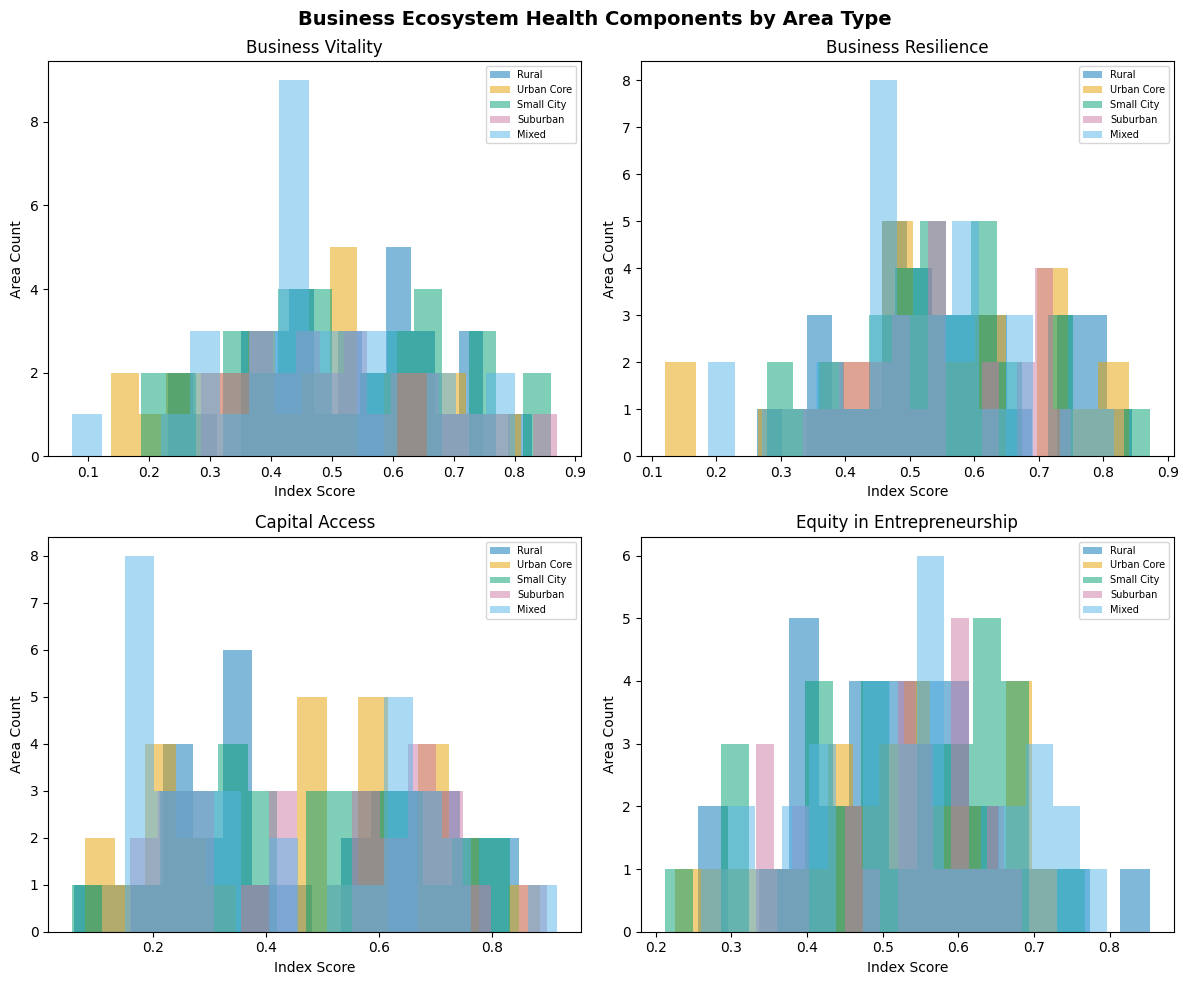

In [5]:
# =============================================================================
# Visualize Health Components by Area Type
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Index distributions by area type
for ax, (col, title) in zip(axes.flatten(), 
                            [('vitality_index', 'Business Vitality'),
                             ('resilience_index', 'Business Resilience'),
                             ('access_index', 'Capital Access'),
                             ('equity_index', 'Equity in Entrepreneurship')]):
    for i, area_type in enumerate(health_data['area_type'].unique()):
        subset = health_data[health_data['area_type'] == area_type][col]
        ax.hist(subset, bins=15, alpha=0.5, label=area_type, color=COLORBLIND_SAFE[i % len(COLORBLIND_SAFE)])
    ax.set_xlabel('Index Score')
    ax.set_ylabel('Area Count')
    ax.set_title(title)
    ax.legend(loc='upper right', fontsize=7)

plt.suptitle('Business Ecosystem Health Components by Area Type', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Minority Business Analysis

In [6]:
# =============================================================================
# Minority Business Outcomes Analysis
# =============================================================================
minority_analysis = health_data.groupby('area_type').agg({
    'minority_owned_pct': 'mean',
    'minority_formation_rate': 'mean',
    'minority_survival_gap': 'mean',
    'formation_rate': 'mean'
}).round(3)

minority_analysis['minority_formation_ratio'] = (
    minority_analysis['minority_formation_rate'] / minority_analysis['formation_rate']
)

print("Minority Business Outcomes by Area Type:")
minority_analysis

Minority Business Outcomes by Area Type:


,minority_owned_pct,minority_formation_rate,minority_survival_gap,formation_rate,minority_formation_ratio
area_type,,,,,
Mixed,0.280,0.109,-0.069,0.138,0.789855
Rural,0.271,0.121,-0.084,0.146,0.828767
Small City,0.278,0.114,-0.079,0.153,0.745098
Suburban,0.272,0.114,-0.077,0.152,0.750000
Urban Core,0.288,0.113,-0.083,0.133,0.849624


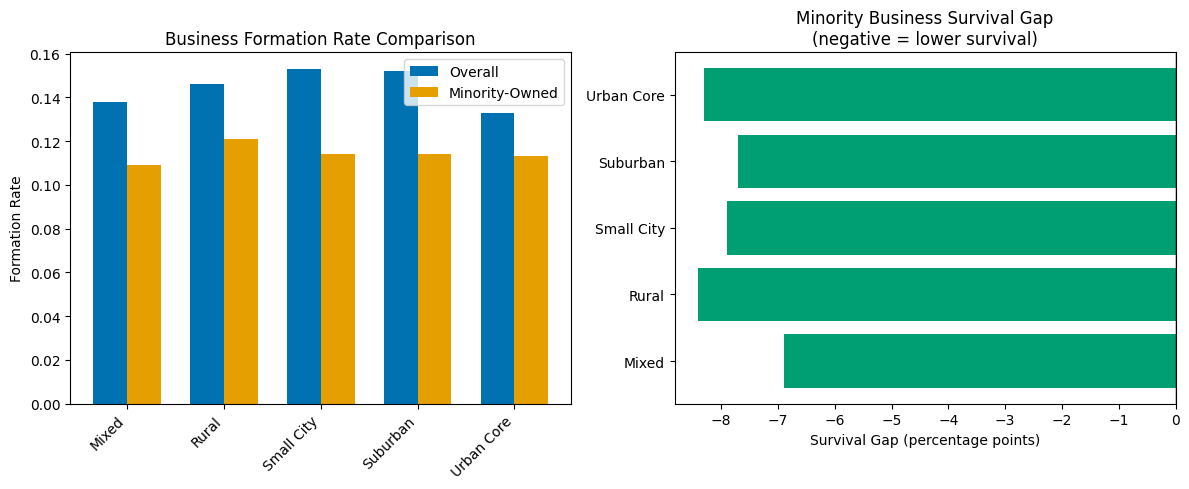

In [7]:
# =============================================================================
# Minority Business Visualization
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Minority vs Overall formation rate
ax1 = axes[0]
x = np.arange(len(minority_analysis))
width = 0.35
ax1.bar(x - width/2, minority_analysis['formation_rate'], width, 
        label='Overall', color=COLORBLIND_SAFE[0])
ax1.bar(x + width/2, minority_analysis['minority_formation_rate'], width,
        label='Minority-Owned', color=COLORBLIND_SAFE[1])
ax1.set_xticks(x)
ax1.set_xticklabels(minority_analysis.index, rotation=45, ha='right')
ax1.set_ylabel('Formation Rate')
ax1.set_title('Business Formation Rate Comparison')
ax1.legend()

# Survival gap by area type
ax2 = axes[1]
colors = [COLORBLIND_SAFE[2] if v < 0 else COLORBLIND_SAFE[3] 
          for v in minority_analysis['minority_survival_gap']]
ax2.barh(minority_analysis.index, minority_analysis['minority_survival_gap'] * 100, color=colors)
ax2.axvline(0, color='black', linewidth=1)
ax2.set_xlabel('Survival Gap (percentage points)')
ax2.set_title('Minority Business Survival Gap\n(negative = lower survival)')

plt.tight_layout()
plt.show()

## 5. Distress Early Warning Indicators

In [8]:
# =============================================================================
# Ecosystem Status Classification with Early Warning Flags
# =============================================================================

def classify_ecosystem_status(df: pd.DataFrame) -> pd.DataFrame:
    """
    Classify areas by ecosystem health status with early warning flags.
    """
    result = df.copy()
    
    # Health classification
    def classify(row):
        score = row['health_percentile']
        trend = row['formation_trend']
        
        if score < 20 and trend < -0.01:
            return 'Critical Distress'
        elif score < 35 or (score < 50 and trend < -0.01):
            return 'At Risk'
        elif score > 70 and trend > 0.01:
            return 'Thriving'
        elif score > 50:
            return 'Healthy'
        else:
            return 'Stable'
    
    result['ecosystem_status'] = result.apply(classify, axis=1)
    
    # Early warning flags
    result['declining_formation'] = result['formation_trend'] < -0.01
    result['declining_survival'] = result['survival_trend'] < -0.005
    result['capital_desert'] = result['access_index'] < 0.25
    result['equity_gap'] = result['minority_survival_gap'] < -0.10
    
    result['warning_flag_count'] = (
        result['declining_formation'].astype(int) +
        result['declining_survival'].astype(int) +
        result['capital_desert'].astype(int) +
        result['equity_gap'].astype(int)
    )
    
    return result

status_data = classify_ecosystem_status(health_data)

# Summary
status_summary = status_data.groupby('ecosystem_status').agg({
    'area_id': 'count',
    'population': 'sum',
    'ecosystem_health_score': 'mean',
    'warning_flag_count': 'mean'
}).round(2)
status_summary.columns = ['Areas', 'Population', 'Avg Health', 'Avg Warnings']

print("Ecosystem Status Classification:")
status_summary

Ecosystem Status Classification:


,Areas,Population,Avg Health,Avg Warnings
ecosystem_status,,,,
At Risk,47,2339218,0.40,1.38
Critical Distress,9,430241,0.34,3.00
Healthy,57,1785780,0.59,0.84
Stable,19,599592,0.49,0.68
Thriving,18,873187,0.63,0.67


In [9]:
# =============================================================================
# Early Warning Flag Analysis
# =============================================================================
warning_cols = ['declining_formation', 'declining_survival', 'capital_desert', 'equity_gap']
warning_names = ['Declining Formation', 'Declining Survival', 'Capital Desert', 'Equity Gap']

warning_rates = {name: status_data[col].mean() for col, name in zip(warning_cols, warning_names)}

print("\nEarly Warning Flag Prevalence:")
for name, rate in sorted(warning_rates.items(), key=lambda x: -x[1]):
    print(f"   {name}: {rate*100:.1f}% of areas")


Early Warning Flag Prevalence:
   Declining Survival: 32.7% of areas
   Equity Gap: 32.0% of areas
   Declining Formation: 24.0% of areas
   Capital Desert: 21.3% of areas


## 6. Sector-Level Analysis

In [10]:
# =============================================================================
# Sector Concentration Analysis
# =============================================================================
from scipy.stats import pearsonr

sector_cols = ['retail_pct', 'food_service_pct', 'professional_services_pct', 'healthcare_pct']
sector_names = ['Retail', 'Food Service', 'Professional Services', 'Healthcare']

# Correlation with ecosystem health
sector_correlations = {}
for col, name in zip(sector_cols, sector_names):
    corr, _ = pearsonr(status_data[col], status_data['ecosystem_health_score'])
    sector_correlations[name] = corr

print("Sector Concentration ↔ Ecosystem Health Correlations:")
for name, corr in sorted(sector_correlations.items(), key=lambda x: -x[1]):
    direction = "↑" if corr > 0 else "↓"
    print(f"   {name}: r = {corr:.3f} {direction}")

Sector Concentration ↔ Ecosystem Health Correlations:
   Professional Services: r = 0.321 ↑
   Retail: r = 0.047 ↑
   Food Service: r = 0.014 ↑
   Healthcare: r = -0.029 ↓


## 7. Key Findings Summary

In [11]:
# =============================================================================
# Executive Summary: Key Findings
# =============================================================================
critical = len(status_data[status_data['ecosystem_status'] == 'Critical Distress'])
at_risk = len(status_data[status_data['ecosystem_status'] == 'At Risk'])
thriving = len(status_data[status_data['ecosystem_status'] == 'Thriving'])

affected_pop = status_data[status_data['ecosystem_status'].isin(['Critical Distress', 'At Risk'])]['population'].sum()
total_pop = status_data['population'].sum()

avg_minority_gap = status_data['minority_survival_gap'].mean() * 100

print("="*70)
print("SMALL BUSINESS ECOSYSTEM HEALTH: KEY FINDINGS")
print("="*70)

print(f"\n📊 ECOSYSTEM STATUS:")
print(f"   • {critical} areas in Critical Distress")
print(f"   • {at_risk} areas At Risk")
print(f"   • {thriving} areas Thriving")
print(f"   • {affected_pop/1e6:.1f}M people in distressed/at-risk areas")

print(f"\n⚖️ EQUITY FINDINGS:")
print(f"   • Average minority survival gap: {avg_minority_gap:.1f} percentage points")
print(f"   • {warning_rates['Equity Gap']*100:.0f}% of areas have significant equity gaps")

print(f"\n⚠️ EARLY WARNING FLAGS:")
print(f"   • {warning_rates['Declining Formation']*100:.0f}% showing declining formation")
print(f"   • {warning_rates['Capital Desert']*100:.0f}% are capital deserts")

print(f"\n💡 POLICY RECOMMENDATIONS:")
print(f"   1. Target capital access programs to underserved areas")
print(f"   2. Address minority business survival gaps")
print(f"   3. Monitor early warning indicators for intervention")
print(f"   4. Support sector diversification in vulnerable areas")

SMALL BUSINESS ECOSYSTEM HEALTH: KEY FINDINGS

📊 ECOSYSTEM STATUS:
   • 9 areas in Critical Distress
   • 47 areas At Risk
   • 18 areas Thriving
   • 2.8M people in distressed/at-risk areas

⚖️ EQUITY FINDINGS:
   • Average minority survival gap: -7.9 percentage points
   • 32% of areas have significant equity gaps

⚠️ EARLY WARNING FLAGS:
   • 24% showing declining formation
   • 21% are capital deserts

💡 POLICY RECOMMENDATIONS:
   1. Target capital access programs to underserved areas
   2. Address minority business survival gaps
   3. Monitor early warning indicators for intervention
   4. Support sector diversification in vulnerable areas


---

## Appendix: KRL Suite Components Used

| Package | Components | Role |
|---------|------------|------|
| **krl-data-connectors** | `CountyBusinessPatternsConnector`, `FREDBasicConnector`, `BLSBasicConnector` | Business and economic data |
| **krl-models** | `LocationQuotientModel`, `ShiftShareModel` | Industry specialization analysis |
| **krl-core** | `get_logger` | Infrastructure utilities |

### Production Data Sources

For production deployment, connect to:
- **Census County Business Patterns** - Establishment counts by industry
- **Census Business Dynamics Statistics** - Entry/exit rates
- **Census Annual Business Survey** - Minority-owned business data
- **SBA Lending Data** - Capital access metrics

### Example Production Usage

```python
from krl_data_connectors.community import CountyBusinessPatternsConnector
from krl_models import LocationQuotientModel

cbp = CountyBusinessPatternsConnector()
data = cbp.get_data(year=2022, geography='county')

lq_model = LocationQuotientModel()
lq_model.fit(data)
specialized = lq_model.get_specialized_industries(region='06037', threshold=1.5)
```

---
*Generated with KRL Suite v2.0 - Community Edition*